In [1]:
import os
#import spacy
import numpy as np
import pandas as pd
from math import log
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data= pd.read_csv("Tweets_5K.csv")
data

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...,...
4995,7dfa892961,look like i can only quick post from the dash...,neutral
4996,b60b7e3175,Thanks Elaine. I`m clipping reviews for her s...,positive
4997,efb00d5c4d,"K now that, that fiasco is all wrapped and goo...",positive
4998,65473dec6e,No. I won`t be back until the 7th,neutral


In [3]:
print('Column Names:')
data.dtypes

Column Names:


textID       object
text         object
sentiment    object
dtype: object

Text(0, 0.5, 'Value')

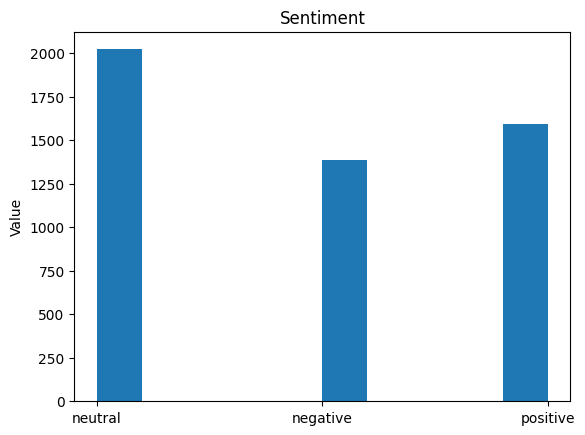

In [4]:
plt.hist(data['sentiment'])
plt.title('Sentiment')
plt.ylabel('Value')

In [5]:
basic_preproc_tweets=data.copy()
basic_preproc_tweets['labels']= basic_preproc_tweets['sentiment'].map({'neutral':0, 'negative':-1, 'positive':1})

In [6]:
basic_preproc_tweets['token']=basic_preproc_tweets['text'].apply(lambda x: x.split())

In [7]:
basic_preproc_tweets

,textID,text,sentiment,labels,token
0,cb774db0d1,"I`d have responded, if I were going",neutral,0,"[I`d, have, responded,, if, I, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,-1,"[Sooo, SAD, I, will, miss, you, here, in, San,..."
2,088c60f138,my boss is bullying me...,negative,-1,"[my, boss, is, bullying, me...]"
3,9642c003ef,what interview! leave me alone,negative,-1,"[what, interview!, leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,-1,"[Sons, of, ****,, why, couldn`t, they, put, th..."
...,...,...,...,...,...
4995,7dfa892961,look like i can only quick post from the dash...,neutral,0,"[look, like, i, can, only, quick, post, from, ..."
4996,b60b7e3175,Thanks Elaine. I`m clipping reviews for her s...,positive,1,"[Thanks, Elaine., I`m, clipping, reviews, for,..."
4997,efb00d5c4d,"K now that, that fiasco is all wrapped and goo...",positive,1,"[K, now, that,, that, fiasco, is, all, wrapped..."
4998,65473dec6e,No. I won`t be back until the 7th,neutral,0,"[No., I, won`t, be, back, until, the, 7th]"


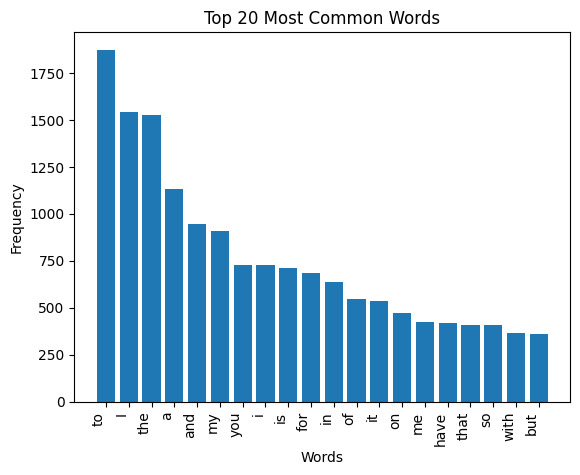

In [8]:
from collections import Counter
all_processed_words = [word for words_list in basic_preproc_tweets['token'] for word in words_list]

word_frequencies = Counter(all_processed_words)

top_n = 20 
top_words, top_frequencies = zip(*word_frequencies.most_common(top_n))

plt.bar(top_words, top_frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words')
plt.xticks(rotation=90, ha='right')
plt.show()

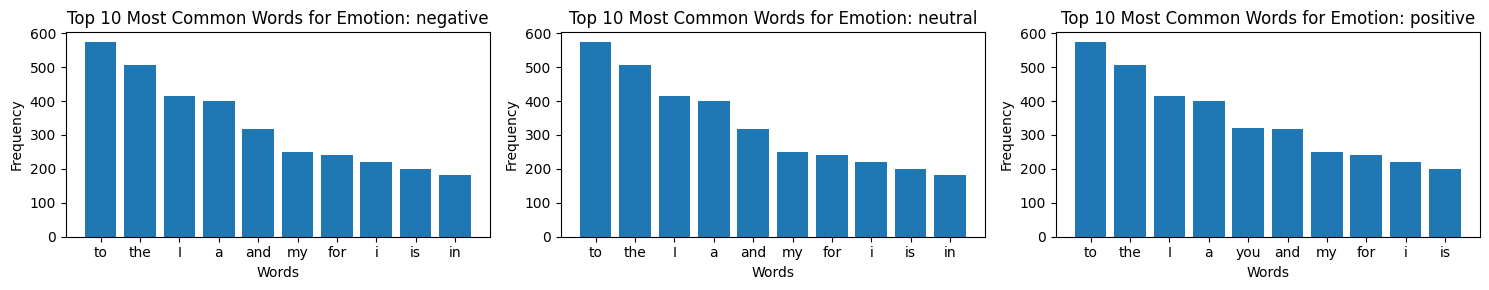

In [9]:
top_words_by_emotion = {}
grouped_df = basic_preproc_tweets.groupby('sentiment')
for emotion, group in grouped_df:
    all_processed_words = [word for words_list in group['token'] for word in words_list]
    word_frequencies = Counter(all_processed_words)
    top_n = 10
    top_words = [word for word, _ in word_frequencies.most_common(top_n)]

    top_words_by_emotion[emotion] = top_words

num_rows = (len(top_words_by_emotion) + 2) // 3
plots_per_row = 3

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 3 * num_rows))
fig.tight_layout(pad=3.0)

axes = axes.flatten()

for i, (emotion, top_words) in enumerate(top_words_by_emotion.items()):
    ax = axes[i]
    sorted_word_frequencies = sorted(
        ((word, word_frequencies[word]) for word in top_words),
        key=lambda x: x[1],
        reverse=True
    )
    
    sorted_words, sorted_frequencies = zip(*sorted_word_frequencies)
    ax.bar(sorted_words, sorted_frequencies)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Top {top_n} Most Common Words for Emotion: {emotion}')

for i in range(len(top_words_by_emotion), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Creating Bag of Words

In [10]:
vectorizer = CountVectorizer(lowercase=False)
word = vectorizer.fit_transform(basic_preproc_tweets['text'])

basic_preproc_tweets_bow = pd.DataFrame(word.toarray(), columns=vectorizer.get_feature_names_out())
basic_preproc_tweets_bow

,00,000,01,07,07XOh,07am,08,09,097dfj,0RPM,...,½ndel,½o,½re,½s,½sseldorf,½sst,½t,½ve,½you,½ï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Converting the bag of words into a numpy array for modelling

In [11]:
np.random.seed(100)
bow_np = basic_preproc_tweets_bow.to_numpy()
x_train, x_test = train_test_split(bow_np, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(basic_preproc_tweets['labels'].to_numpy(), test_size=0.2, shuffle=False)

In [12]:
print(x_train.shape)
print(y_train.shape)

(4000, 10849)
(4000,)


### Questions to answer and hand-in (you may need to write additional code and/or print
statements to answer these questions):
1. What are the dimensions of your feature matrix (X)?
2. What is the value of X[1460][1460]?
3. What does this value mean? What feature does the 1460th column represent?

In [13]:
print(bow_np.shape)
print(x_train.shape)

(5000, 10849)
(4000, 10849)


Size of features before splitting is 10849 </br>
Size of features after splitting for train is 10849

In [14]:
x_train[1460][1460]

0

value of X[1460][1460] is 0

In [15]:
basic_preproc_tweets_bow.columns[1460]

'Gottta'

#### This Value gives us that the Doument 1461(python numbering starts from 0) the value of word Gottta is 0

## Part 2: Implementing Naive Bayes

### Implement and run Naive Bayes

In [16]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_train)

In [17]:
print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Accuracy: 0.9075
              precision    recall  f1-score   support

          -1       0.94      0.87      0.90      1120
           0       0.87      0.93      0.90      1596
           1       0.93      0.91      0.92      1284

    accuracy                           0.91      4000
   macro avg       0.91      0.90      0.91      4000
weighted avg       0.91      0.91      0.91      4000



### Report the model’s accuracy on the unseen test set. How does this compare to a classifier that always outputs the most frequent category in the training set (what is that classifier’s accuracy)?)?

In [18]:
y_pred_test=classifier.predict(x_test)

In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.591
              precision    recall  f1-score   support

          -1       0.57      0.49      0.53       265
           0       0.55      0.62      0.58       427
           1       0.67      0.64      0.65       308

    accuracy                           0.59      1000
   macro avg       0.60      0.58      0.59      1000
weighted avg       0.59      0.59      0.59      1000



In [20]:
most_freq_class=([0]*len(y_test))
print("Accuracy:", accuracy_score(y_test, most_freq_class))
print(classification_report(y_test, most_freq_class))

Accuracy: 0.427
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       265
           0       0.43      1.00      0.60       427
           1       0.00      0.00      0.00       308

    accuracy                           0.43      1000
   macro avg       0.14      0.33      0.20      1000
weighted avg       0.18      0.43      0.26      1000



C:\Users\sagar\anaconda3\envs\nn_dl\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sagar\anaconda3\envs\nn_dl\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sagar\anaconda3\envs\nn_dl\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### The Accuracy of the Most freq Classifier is worse than our model, although the model performs poorly on the unseen data compared to the training data. It performs better than the baseline of just classifying everything as Neutral the most frequent class

#### 1. Calculate whether the Naive Bayes classifier you trained would classify the following tweet as positive, neutral, or negative: “Happy birthday Annemarie”.

#### Priors

In [21]:
t_neutral=0
t_negative=0
t_positive=0
for i in y_train:
    if i==0:
        t_neutral=t_neutral+1
    elif i==-1:
        t_negative=t_negative+1
    else:
        t_positive=t_positive+1
print(t_neutral)
print(t_negative)
print(t_positive)
pneu=t_neutral/len(x_train)
pneg=t_negative/len(x_train)
ppos=t_positive/len(x_train)
print(pneu)
print(pneg)
print(ppos)

1596
1120
1284
0.399
0.28
0.321


In [22]:
basic_preproc_tweets_bow.columns.get_loc('Happy')

1561

In [23]:
basic_preproc_tweets_bow.columns.get_loc('birthday')

4371

In [24]:
#basic_preproc_tweets_bow.columns.get_loc('Annie')

$ p(w_i|c) = \frac{count (w_i,c)+1}{\sum_{w \in V}{count(w,c)}+1}$

In [25]:
b_neutral=0
b_negative=0
b_positive=0
for i in range(len(x_train)):
    if x_train[i][basic_preproc_tweets_bow.columns.get_loc('birthday')]==1:
        if y_train[i]==0:
            b_neutral=b_neutral+1
        elif y_train[i]==-1:
            b_negative=b_negative+1
        else:
            b_positive=b_positive+1

In [26]:
print(b_neutral)
print(b_negative)
print(b_positive)
p_birthday_neu=(b_neutral+1)/t_neutral
p_birthday_neg=(b_negative+1)/t_negative
p_birthday_pos=(b_positive+1)/t_positive
print(p_birthday_neu)
print(p_birthday_neg)
print(p_birthday_pos)

7
2
11
0.005012531328320802
0.0026785714285714286
0.009345794392523364


In [27]:
h_neutral=0
h_negative=0
h_positive=0
for i in range(len(x_train)):
    if x_train[i][basic_preproc_tweets_bow.columns.get_loc('Happy')]==1:
        if y_train[i]==0:
            h_neutral=h_neutral+1
        elif y_train[i]==-1:
            h_negative=h_negative+1
        else:
            h_positive=h_positive+1

In [28]:
print(h_neutral)
print(h_negative)
print(h_positive)
p_Happy_neu=(h_neutral+1)/t_neutral
p_Happy_neg=(h_negative+1)/t_negative
p_Happy_pos=(h_positive+1)/t_positive
print(p_Happy_neu)
print(p_Happy_neg)
print(p_Happy_pos)

4
2
59
0.003132832080200501
0.0026785714285714286
0.04672897196261682


### P(Positive)

In [29]:
PPos=ppos*p_Happy_pos*p_birthday_pos
print(PPos)

0.00014018691588785044


### P(Negative)

In [30]:
PNeg=pneg*p_Happy_neg*p_birthday_neg
print(PNeg)

2.008928571428572e-06


### P(Neutral)

In [31]:
PNeu=pneu*p_Happy_neu*p_birthday_neu
print(PNeu)

6.265664160401002e-06


### The Probability of Positive class is higher and therefore it would be classified as Positive

## Part 3: Implementing Logistic Regression

In [32]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_train)

In [33]:
print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Accuracy: 0.97775
              precision    recall  f1-score   support

          -1       0.98      0.97      0.98      1120
           0       0.97      0.98      0.98      1596
           1       0.99      0.98      0.98      1284

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



#### How many parameters did your multiclass logistic regression model learn??

In [34]:
x_test.shape

(1000, 10849)

Therefore the no of parameters learnt is No of Classes x (No of Features + inercept) </br>
3x(10849+1)

In [35]:
3*(10849+1)

32550

#### Report the model’s accuracy on the unseen test set. How does this compare to a classifier that always outputs the most frequent category in the training set and the Naive Bayes classifier from Part 2?2?

In [36]:
y_pred_test=classifier.predict(x_test)

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.606
              precision    recall  f1-score   support

          -1       0.55      0.47      0.51       265
           0       0.57      0.67      0.62       427
           1       0.71      0.64      0.67       308

    accuracy                           0.61      1000
   macro avg       0.61      0.59      0.60      1000
weighted avg       0.61      0.61      0.60      1000



### The Accuracy of the Most freq Classifier is worse than our Logistic regression model, although the model performs poorly on the unseen data compared to the training data. It performs better than the baseline of just classifying everything as Neutral the most frequent class.

### The performce of the Naive Bias v/s Logistic regression is very similar on the unseen data where the Logistic Regression model just mariginally out performs the Naive Bias Model

## Part 4: Implementing more elaborate pre-processing

### Performing Tokenization and Lemmatization along with removal of stop words

In [38]:
basic_preproc_tweets2=data.copy()
basic_preproc_tweets2['labels']= basic_preproc_tweets['sentiment'].map({'neutral':0, 'negative':-1, 'positive':1})

In [39]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    
    return [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in string.punctuation] if not filtered_words else filtered_words

basic_preproc_tweets2['token'] = basic_preproc_tweets2['text'].apply(tokenize_text)

print(basic_preproc_tweets2[['text', 'token']])

                                                   text  \
0                   I`d have responded, if I were going   
1         Sooo SAD I will miss you here in San Diego!!!   
2                             my boss is bullying me...   
3                        what interview! leave me alone   
4      Sons of ****, why couldn`t they put them on t...   
...                                                 ...   
4995   look like i can only quick post from the dash...   
4996   Thanks Elaine. I`m clipping reviews for her s...   
4997  K now that, that fiasco is all wrapped and goo...   
4998                  No. I won`t be back until the 7th   
4999  Sooo tired and have a headache-all self inflic...   

                                                  token  
0                                    [responded, going]  
1                         [sooo, sad, miss, san, diego]  
2                                       [bos, bullying]  
3                             [interview, leave, alone]  
4

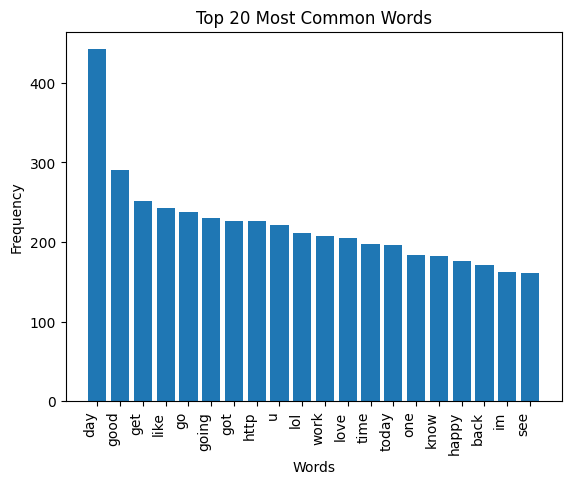

In [40]:
from collections import Counter
all_processed_words = [word for words_list in basic_preproc_tweets2['token'] for word in words_list]

word_frequencies = Counter(all_processed_words)

top_n = 20 
top_words, top_frequencies = zip(*word_frequencies.most_common(top_n))

plt.bar(top_words, top_frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words')
plt.xticks(rotation=90, ha='right')
plt.show()

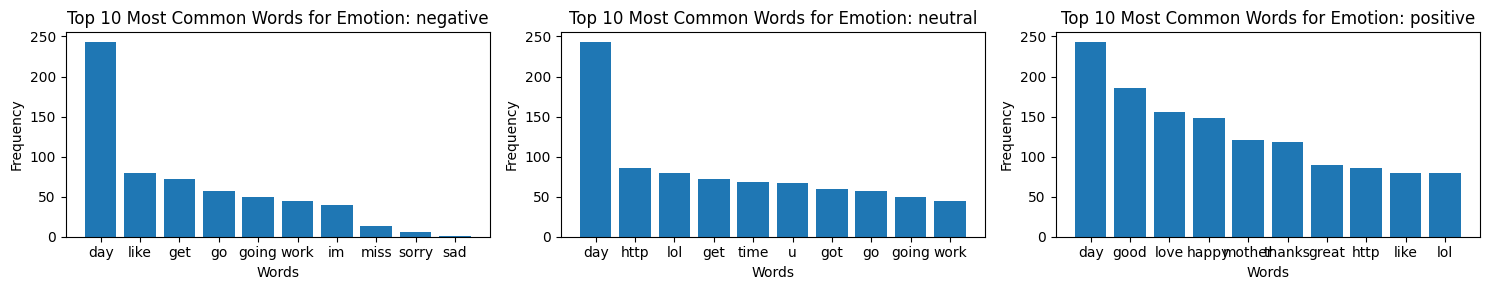

In [41]:
top_words_by_emotion = {}
grouped_df = basic_preproc_tweets2.groupby('sentiment')
for emotion, group in grouped_df:
    all_processed_words = [word for words_list in group['token'] for word in words_list]
    word_frequencies = Counter(all_processed_words)
    top_n = 10
    top_words = [word for word, _ in word_frequencies.most_common(top_n)]

    top_words_by_emotion[emotion] = top_words

num_rows = (len(top_words_by_emotion) + 2) // 3
plots_per_row = 3

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 3 * num_rows))
fig.tight_layout(pad=3.0)

axes = axes.flatten()

for i, (emotion, top_words) in enumerate(top_words_by_emotion.items()):
    ax = axes[i]
    sorted_word_frequencies = sorted(
        ((word, word_frequencies[word]) for word in top_words),
        key=lambda x: x[1],
        reverse=True
    )
    
    sorted_words, sorted_frequencies = zip(*sorted_word_frequencies)
    ax.bar(sorted_words, sorted_frequencies)
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Top {top_n} Most Common Words for Emotion: {emotion}')

for i in range(len(top_words_by_emotion), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Creating Bag of words with top 1000 words and one OOV word

In [42]:
basic_preproc_tweets2['text2']=basic_preproc_tweets2['token'].apply(lambda text: ' '.join(text))

In [43]:
vectorizer = CountVectorizer(max_features=1000)
word = vectorizer.fit_transform(basic_preproc_tweets2['text2'])

In [44]:
basic_preproc_tweets_bow2 = pd.DataFrame(word.toarray(), columns=vectorizer.get_feature_names_out())
basic_preproc_tweets_bow2['OOV']=0
basic_preproc_tweets_bow2

,10,12,15,1st,20,24,25,2day,2nite,30,...,yep,yes,yesterday,yet,young,youtube,yr,yum,yummy,OOV
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
bow_np = basic_preproc_tweets_bow2.to_numpy()
x_train, x_test = train_test_split(bow_np, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(basic_preproc_tweets2['labels'].to_numpy(), test_size=0.2, shuffle=False)

#### Implementing Naive Bias

In [46]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Accuracy: 0.73675
              precision    recall  f1-score   support

          -1       0.76      0.68      0.72      1120
           0       0.70      0.77      0.73      1596
           1       0.77      0.75      0.76      1284

    accuracy                           0.74      4000
   macro avg       0.74      0.73      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [47]:
y_pred_test=classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.607
              precision    recall  f1-score   support

          -1       0.61      0.49      0.54       265
           0       0.57      0.64      0.60       427
           1       0.67      0.66      0.66       308

    accuracy                           0.61      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.61      0.61      0.61      1000



#### Implementing Logistic Regression

In [48]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Accuracy: 0.79925
              precision    recall  f1-score   support

          -1       0.83      0.72      0.77      1120
           0       0.74      0.86      0.79      1596
           1       0.87      0.79      0.83      1284

    accuracy                           0.80      4000
   macro avg       0.81      0.79      0.80      4000
weighted avg       0.81      0.80      0.80      4000



In [49]:
y_pred_test=classifier.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.631
              precision    recall  f1-score   support

          -1       0.59      0.48      0.53       265
           0       0.59      0.68      0.63       427
           1       0.72      0.70      0.71       308

    accuracy                           0.63      1000
   macro avg       0.63      0.62      0.62      1000
weighted avg       0.63      0.63      0.63      1000



### How does this impact the performance of your Naive Bayes and Logistic Regression classification results?

In [50]:
old_naive=[0.591]*10
old_logistic=[0.606]*10
new_naive=[0.607]*10
new_logistic=[0.631]*10
most_freq=[0.427]*10
x=list(range(10))

In [51]:
0.631-0.606

0.025000000000000022

Text(0.5, 1.0, 'Comparing Result on Unseen Data')

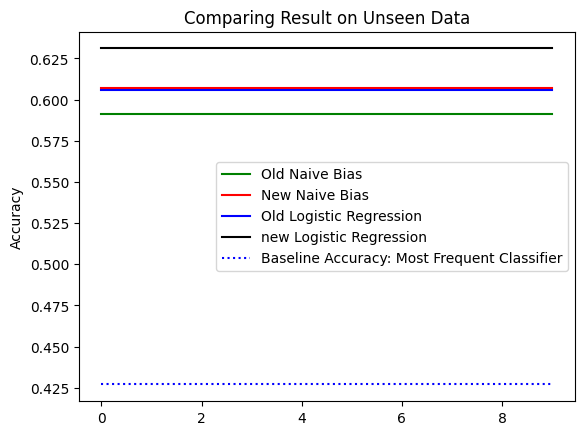

In [52]:
plt.plot(x,old_naive, color='green', label='Old Naive Bias')
plt.plot(x,new_naive, color='red', label='New Naive Bias')
plt.plot(x,old_logistic, color='blue', label='Old Logistic Regression')
plt.plot(x,new_logistic, color='black', label='new Logistic Regression')
plt.plot(x, most_freq, linestyle='dotted', color='b', label='Baseline Accuracy: Most Frequent Classifier')

plt.legend()
plt.ylabel('Accuracy')
plt.title('Comparing Result on Unseen Data')

#### Improvement in Naive Bias is 1.6% on unseen data

#### Improvement in Logistic Regression is 2.5% on unseen data

## Part 5

#### Propose and implement at least one addition to the workflow that you think will improve Performace(

#### Implementing Tf-Idf should improve performace as it would give importance to each term </br>
We will perform Tf-Idf on the processed text generated in part 3

In [53]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(basic_preproc_tweets2['text2'])
basic_preproc_tweets_bow3 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
basic_preproc_tweets_bow3

,10,12,15,1st,20,24,25,2day,2nite,30,...,year,yep,yes,yesterday,yet,young,youtube,yr,yum,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
bow_np = basic_preproc_tweets_bow3.to_numpy()
x_train, x_test = train_test_split(bow_np, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(basic_preproc_tweets2['labels'].to_numpy(), test_size=0.2, shuffle=False)

In [55]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))


Accuracy: 0.7245
              precision    recall  f1-score   support

          -1       0.82      0.58      0.68      1120
           0       0.64      0.84      0.73      1596
           1       0.81      0.71      0.75      1284

    accuracy                           0.72      4000
   macro avg       0.76      0.71      0.72      4000
weighted avg       0.75      0.72      0.72      4000



In [56]:
y_pred_test=classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.602
              precision    recall  f1-score   support

          -1       0.68      0.37      0.48       265
           0       0.55      0.75      0.63       427
           1       0.68      0.60      0.63       308

    accuracy                           0.60      1000
   macro avg       0.63      0.57      0.58      1000
weighted avg       0.62      0.60      0.59      1000



In [57]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Accuracy: 0.76225
              precision    recall  f1-score   support

          -1       0.81      0.66      0.73      1120
           0       0.70      0.84      0.76      1596
           1       0.84      0.75      0.79      1284

    accuracy                           0.76      4000
   macro avg       0.78      0.75      0.76      4000
weighted avg       0.77      0.76      0.76      4000



In [58]:
y_pred_test=classifier.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.634
              precision    recall  f1-score   support

          -1       0.63      0.45      0.53       265
           0       0.58      0.72      0.65       427
           1       0.73      0.67      0.70       308

    accuracy                           0.63      1000
   macro avg       0.65      0.61      0.62      1000
weighted avg       0.64      0.63      0.63      1000



### The New Logistic regression with Tf-Idf implemented is the best model on the unseen data so far. But it Marginally outperforms the Logistic regression Model generated in Part 3 by 0.3%

### Althought the performance improve we can say that the implementation of Tf-idf can be considered as insignificant for this scenario.

Finally, take the best performing model and look at the tweets that were incorrectly
categorized. Do you observe any patterns in what the model is making mistakes on?
What do you think could be done to further improve results?

In [59]:
y_pred = classifier.predict(bow_np)
incorr=[]
for i in range(len(y_pred)):
    if y_pred[i]!=basic_preproc_tweets2['labels'][i]:
        incorr.append(i)

for i in range(len(incorr)):
    if i%10==0:
        print(basic_preproc_tweets2.loc[incorr[i]])
        print()

In [64]:
print(basic_preproc_tweets2.loc[1299])
print(y_pred[1299])

textID                                       f854b71b06
text          hell yeah! Belgian beer is the bomb!!  :p
sentiment                                      positive
labels                                                1
token              [hell, yeah, belgian, beer, bomb, p]
text2                     hell yeah belgian beer bomb p
Name: 1299, dtype: object
0


In [67]:
print(basic_preproc_tweets2.loc[4093])
print(y_pred[4093])

textID                                              6c344c1dac
text         Watching my fav movie...Two Can Play That Game...
sentiment                                             positive
labels                                                       1
token        [watching, fav, movie, two, play, game, notice...
text2        watching fav movie two play game notice men st...
Name: 4093, dtype: object
0


In [74]:
print(basic_preproc_tweets2.loc[4719])
print(y_pred[4719])

textID                                              df334d0c28
text         - NOT A HEAP HEY. JUST BOUT TU HIT THE SACK. I...
sentiment                                             negative
labels                                                      -1
token        [heap, hey, bout, tu, hit, sack, need, someone...
text2        heap hey bout tu hit sack need someone tu cudd...
Name: 4719, dtype: object
0


1. Some of the tweets has slangs in them which would not be mapped to the actual word when we are tokenizing and therefore decreasing the importance of that word.
2. Some of the tweets are Case sensitive, i.e. the person tweeted it in caps to show strong emotion, and if we lower the caption it might have decreased its meaning.
3. Lot of emojis used have been cleaned out. Emojis can help in understanding the sentiment of tweet.

Solutions
1. Try to create a mapping of slangs to their respective actual English words as not everyone types in that manner.
2. Create two vectors for words in all CAP's respectively to help distinguish the two and give importance to the tweets with Words in Caps or create a feature called isCap Y/N.
3. Create vectors for emojis used in the tweets

#### Roughly how much time did you spend on this homework?

About 6 hours spread over multiple days.